In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/SOX9/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [3]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_idr_fw_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)
# # OPTIONAL: drop bad qc samples
# tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
# df = df.loc[:, tst]
# mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./annotated_peaks/ann_raw_idr_fw_peaks_merged_filtered.txt', sep='\t')

In [4]:
mat.columns.str.split('/').str[-1]

Index(['00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC',
       '00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT',
       '01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l20200911_CATAGAGT_TGCCACCA',
       '01_mouse_BL6_M_3week_SOX9main_ChIP_H3K27ac_2_AL_l20200925_AGTACTCC_AACCTGTT',
       '02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA'],
      dtype='object')

# Run differential peak analysis

In [5]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./annotated_peaks/ann_raw_idr_fw_peaks_merged_filtered.txt \
# 00_sox9_10day 00_sox9_10day \
# 01_sox9_3week 01_sox9_3week \
# 02_sox9_4month 02_sox9_4month 02_sox9_4month \
# -peaks > ./diff_fw_output.txt

In [6]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./annotated_peaks/ann_raw_idr_fw_peaks_merged_filtered.txt \
# 00_sox9_young 00_sox9_young \
# 00_sox9_young 00_sox9_young \
# 02_sox9_old 02_sox9_old 02_sox9_old \
# -peaks > ./diff_fw_output_youngpool.txt

# Create summary plots

## 10day vs. 4 months

In [7]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_fw_output.txt',
    './annotated_peaks/ann_raw_idr_fw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (32143, 25)
getDiffExpression selected transcripts (31410, 31)
annotatePeaks selected peaks (31410, 25)


In [8]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [9]:
comps = ['00_sox9_10day vs. 02_sox9_4month']

cols = [[0,1,4,5,6]]

groups = [[[0,1],[4,5,6]]]

colors = [['#3182bd', '#de2d26']]

00_sox9_10day vs. 02_sox9_4month
N genes downregulated 3540
N genes upregulated 4700



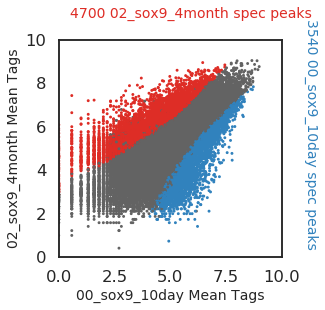

In [10]:
fc = np.log2(2)
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,11,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(11,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

## Pooled young (10 day and 21 day) vs. 4 month

In [11]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_fw_output_youngpool.txt',
    './annotated_peaks/ann_raw_idr_fw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (32143, 25)
getDiffExpression selected transcripts (31410, 28)
annotatePeaks selected peaks (31410, 25)


In [12]:
comp_dict.keys()

dict_keys(['00_sox9_young vs. 02_sox9_old'])

In [13]:
comps = ['00_sox9_young vs. 02_sox9_old']

cols = [[0,1,2,3,4,5,6]]

groups = [[[0,1,2,3],[4,5,6]]]

colors = [['#3182bd', '#de2d26']]

00_sox9_young vs. 02_sox9_old
N genes downregulated 680
N genes upregulated 340



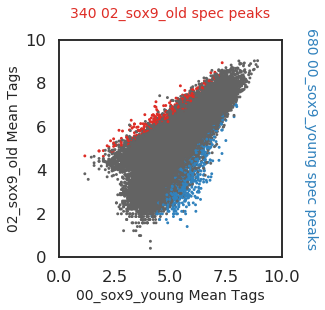

In [14]:
fc = np.log2(2)
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')
    fig, ax = plt.subplots(figsize=(4,4))
    
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,11,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(11,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_youngpool_scatter.png', bbox_inches='tight')
    # plt.close()

# Looking at this we will proceed with an analysis of the 10 day and 4 month data.

In [15]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_fw_output.txt',
    './annotated_peaks/ann_raw_idr_fw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (32143, 25)
getDiffExpression selected transcripts (31410, 31)
annotatePeaks selected peaks (31410, 25)


In [16]:
comp_dict.keys()

dict_keys(['00_sox9_10day vs. 01_sox9_3week', '00_sox9_10day vs. 02_sox9_4month'])

# Extract peaks for an analysis in GREAT

In [17]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_sox9_10day', '02_sox9_4month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_sox9_10day ...

0
For comp: 00_sox9_10day vs. 01_sox9_3week
Union set at: 3 peaks
Intersection set at: 3 peaks

1
For comp: 00_sox9_10day vs. 02_sox9_4month
Union set at: 3540 peaks
Intersection set at: 3 peaks

Analyzing 02_sox9_4month ...

0
For comp: 00_sox9_10day vs. 01_sox9_3week
Union set at: 3540 peaks
Intersection set at: 3 peaks

0
For comp: 00_sox9_10day vs. 02_sox9_4month
Union set at: 4700 peaks
Intersection set at: 4700 peaks



In [18]:
peak_lists.keys()

dict_keys(['00_sox9_10day_union', '00_sox9_10day_intersection', '02_sox9_4month_union', '02_sox9_4month_intersection'])

### Save peak and bed files for GREAT analysis

In [19]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [20]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4].to_csv(
        './great_analysis/peak_files/'+key+'_act_peaks.txt',
        sep='\t')

Save full set of peaks for background

In [21]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/sox9_all_peaks.txt',
    sep='\t')

Convert to bed files

In [22]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [23]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [28]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [29]:
!cp ./great_analysis/bed_files/*union* ./bed_files/

In [30]:
!ls ./bed_files/

00_sox9_10day_union_act_peaks.bed   fw_peaks_merged.bed   vw_peaks_merged.bed
02_sox9_4month_union_act_peaks.bed  nfr_peaks_merged.bed


Give track names for uploading to genome browser

In [31]:
%%bash

echo 'track name="Sox9_H3K27Ac_10day_peaks" description="Sox9 Nuclei 10day H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/00_sox9_10day_union_act_peaks.bed \
> temp && mv temp ./bed_files/00_sox9_10day_union_act_peaks.bed

echo 'track name="Sox9_H3K27Ac_4month_peaks" description="Sox9 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/02_sox9_4month_union_act_peaks.bed \
> temp && mv temp ./bed_files/02_sox9_4month_union_act_peaks.bed

Next step... check these peaks on browser to make sure they look specific

In [32]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [35]:
diff_peak.sort_values('00_sox9_10day vs. 02_sox9_4month adj. p-value', ascending=True).head(10)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA,00_sox9_10day vs. 01_sox9_3week Log2 Fold Change,00_sox9_10day vs. 01_sox9_3week p-value,00_sox9_10day vs. 01_sox9_3week adj. p-value,00_sox9_10day vs. 02_sox9_4month Log2 Fold Change,00_sox9_10day vs. 02_sox9_4month p-value,00_sox9_10day vs. 02_sox9_4month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr6-31454913-3,chr6,31454409,31455409,+,170.300003,./peak_files/01_mouse_BL6_M_3week_SOX9main_ChI...,"intron (NM_013791, intron 8 of 17)","intron (NM_013791, intron 8 of 17)",56081.0,NM_013791,...,7.634851,7.652103,8.103932,3.776185,4.120817e-08,0.000543,4.367656,1.134155e-29,3.562381e-25,chr6:31454409-31455409
Merged-chr4-127986734-2,chr4,127986234,127987234,+,226.500000,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,Intergenic,Intergenic,-1310.0,NM_001281955,...,4.912806,4.810258,4.414624,-2.085424,6.181132e-03,0.361948,-3.624492,7.206804e-27,1.131829e-22,chr4:127986234-127987234
Merged-chr15-82379309-1,chr15,82378809,82379809,+,236.100006,./peak_files/03_mouse_MPSIIIAhet_M_4month_SOX9...,"intron (NM_019823, intron 1 of 9)",(TTCC)n|Simple_repeat|Simple_repeat,951.0,NM_019823,...,7.895594,8.378547,8.438771,2.189449,2.164494e-04,0.090303,3.120743,1.630038e-26,1.706650e-22,chr15:82378809-82379809
Merged-chr14-32302336-5,chr14,32301809,32302809,+,151.199997,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,Intergenic,Intergenic,-19710.0,NM_001081130,...,7.727495,7.912117,8.217660,2.797925,1.108979e-05,0.017100,3.114786,1.641384e-25,1.288897e-21,chr14:32301809-32302809
Merged-chr4-129514129-3,chr4,129513614,129514614,+,194.000000,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_010807, intron 1 of 1)",CpG,533.0,NM_010807,...,4.726630,5.197198,5.008809,-1.557678,4.337086e-02,0.629274,-3.270596,2.766368e-24,1.737833e-20,chr4:129513614-129514614
Merged-chr9-44085850-4,chr9,44085307,44086307,+,162.350006,./peak_files/01_mouse_BL6_M_3week_SOX9_ChIP_H3...,"intron (NM_198091, intron 1 of 11)","intron (NM_198091, intron 1 of 11)",887.0,NM_198091,...,7.448921,7.828861,7.834618,2.236579,1.963064e-03,0.230876,3.199591,3.744112e-24,1.818550e-20,chr9:44085307-44086307
Merged-chr10-27388404-2,chr10,27387904,27388904,+,111.349998,./peak_files/01_mouse_BL6_M_3week_SOX9main_ChI...,"intron (NM_008481, intron 4 of 63)","intron (NM_008481, intron 4 of 63)",-1462.0,NR_131034,...,7.152522,7.593077,7.504021,3.040696,8.906926e-05,0.058862,3.972670,4.052801e-24,1.818550e-20,chr10:27387904-27388904
Merged-chr11-110448772-4,chr11,110448233,110449233,+,119.474998,./peak_files/01_mouse_BL6_M_3week_SOX9_ChIP_H3...,"intron (NM_001356352, intron 1 of 11)",(CA)n|Simple_repeat|Simple_repeat,-29782.0,NM_001356347,...,6.980125,7.431523,7.638371,3.026682,1.124256e-03,0.174893,4.619714,1.207036e-23,4.739123e-20,chr11:110448233-110449233
Merged-chr17-47508084-2,chr17,47507584,47508584,+,160.600006,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_001081635, intron 1 of 6)","intron (NM_001081635, intron 1 of 6)",3033.0,NM_001081635,...,7.087876,7.480262,7.747708,3.557100,1.203431e-05,0.017580,4.294347,7.479850e-23,2.610468e-19,chr17:47507584-47508584


At this enhancer we can see that the fixed width peak does in fact miss the nucleosome free region associated with the enhancer - so theoretically would miss the motif as well.
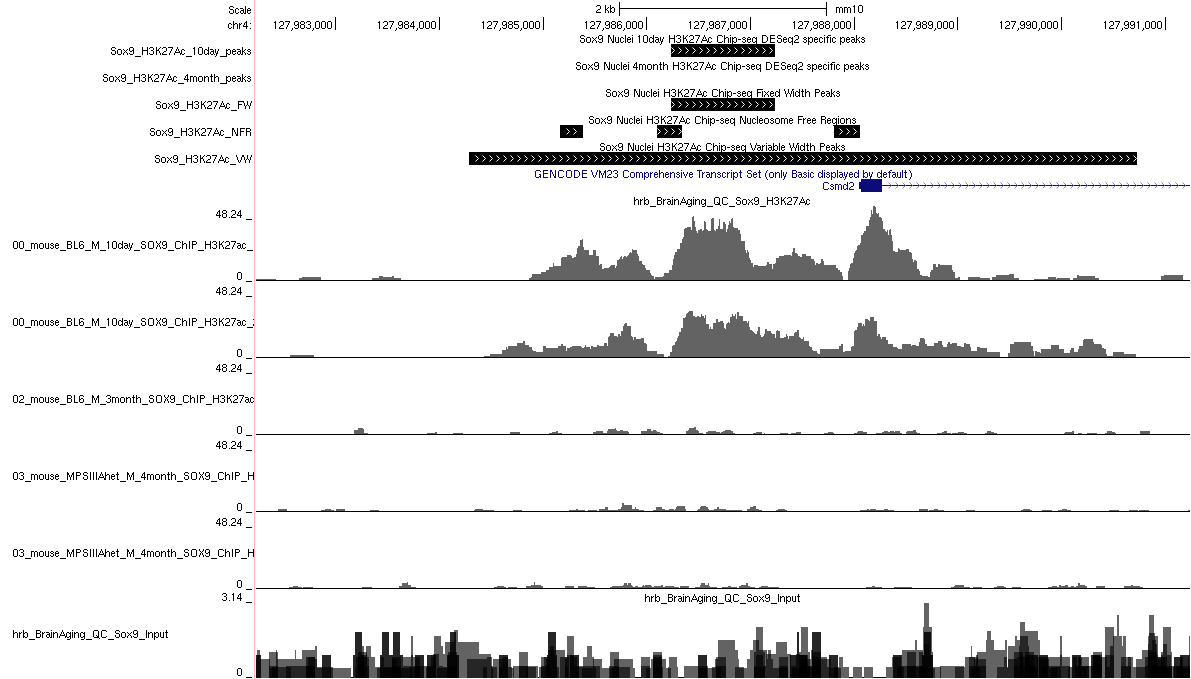
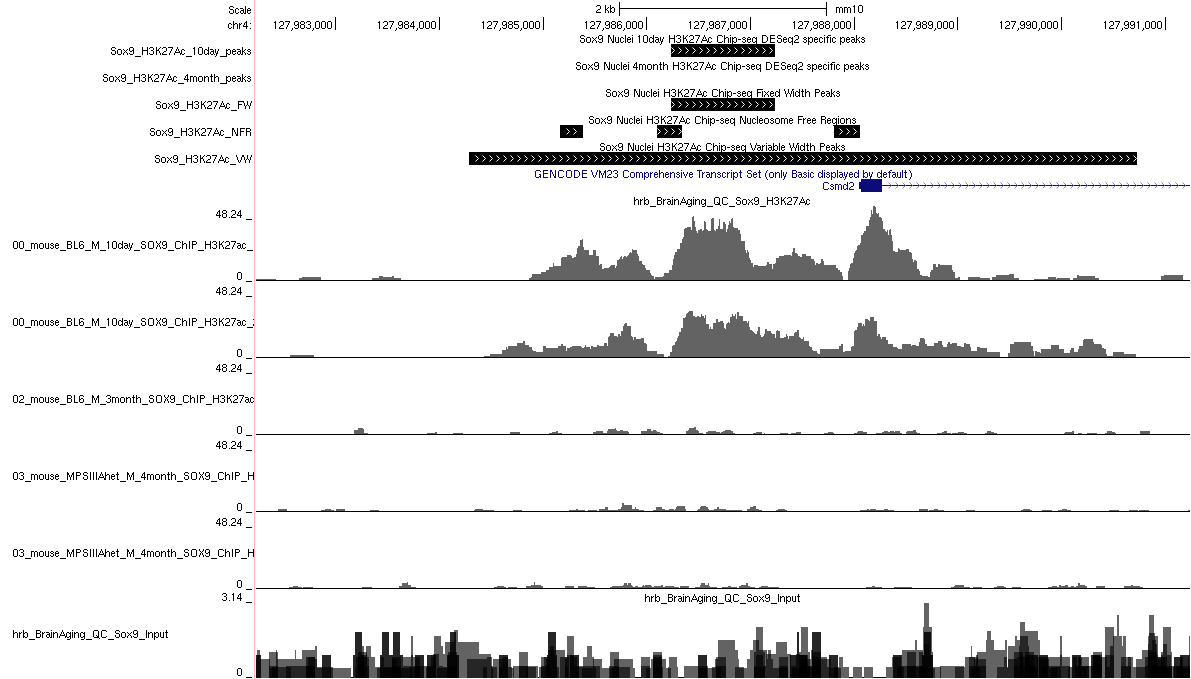